In [13]:
import pandas as pd
import nltk
nltk.download('wordnet')
from nltk import WordNetLemmatizer
from sklearn.cluster import KMeans

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/srinithisrinivasan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
df = pd.read_csv('twitter_data_v1_cleaned_with_location.csv')
df = df.dropna()


/Users/srinithisrinivasan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [15]:
list_tokens = [i.strip('][').split(', ') for i in list(df['tokens'])]

list_tokens_clean = []

for tokens in list_tokens:
    bucket = []
    for token in tokens:
        
        bucket.append(token.replace("'", ""))
        
    list_tokens_clean.append(bucket)
    


In [16]:
lemmatizer = WordNetLemmatizer()

def lemmatize_fn(text):
    text_lemmatized = [lemmatizer.lemmatize(token) for token in text]
    return text_lemmatized
    
list_lemmatized = [lemmatize_fn(text) for text in list_tokens_clean]

In [17]:
df['lemmatized_text'] = list_lemmatized

In [6]:
df.to_csv('for_bert.csv')

In [18]:
list_strings = [' '.join(i) for i in list_lemmatized]

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(list_strings)

In [21]:
from sklearn.cluster import KMeans

kmeans_ti = KMeans(n_clusters = 3).fit(X)
df['clusters'] = kmeans_ti.labels_

In [35]:
#Change cluster numbers to see frequency of words in each of them

from collections import Counter

main_list = list(df[df.clusters == 2]["lemmatized_text"])

#print(len(list(df[df.clusters == 3]["lemmatized_text"])))

flat_list = [i for item in main_list for i in item]
                 
dict_count = dict(Counter(flat_list))

#dict(sorted(dict_count.items(), key = lambda item: item[1], reverse = True))
    

In [33]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

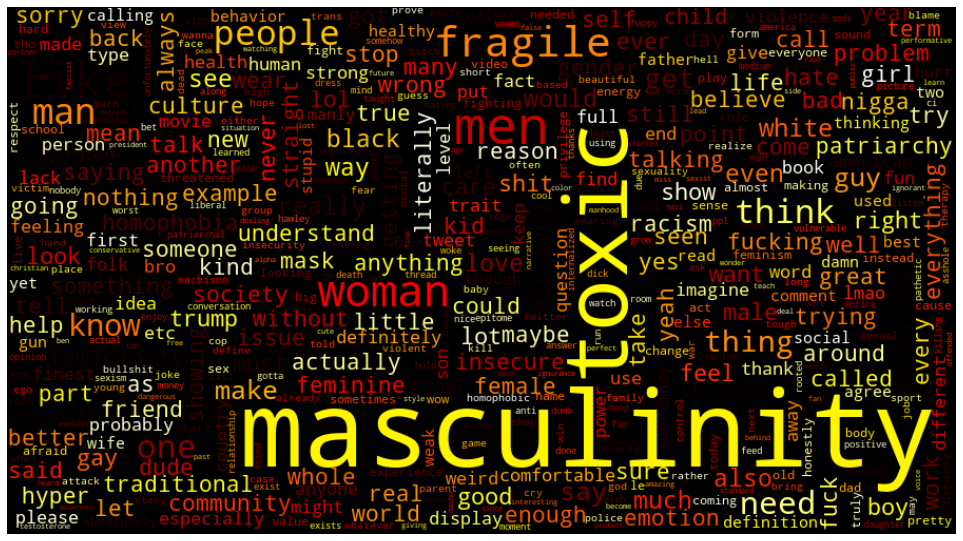

In [36]:

wordfreq = Counter(flat_list)

# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='hot',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)

plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [45]:
from gensim.models import Word2Vec

In [46]:
model = Word2Vec(sentences = list_lemmatized, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [47]:
#Taking mean of word vectors for each tweet
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  
            continue
    if count != 0:
        vec /= count
    return vec

In [48]:
import numpy as np

wordvec_arrays = np.zeros((len(list_lemmatized), 100)) 
for i in range(len(list_lemmatized)):
    wordvec_arrays[i,:] = word_vector(list_lemmatized[i], 100)

In [49]:
wordvec_arrays.shape

(53414, 100)

In [64]:
from sklearn.cluster import KMeans

kmeans_w2v = KMeans(n_clusters = 5).fit(wordvec_arrays)

df['clusters_wv'] = kmeans_w2v.labels_

In [71]:
#Change cluster numbers to see frequency of words in each of them

from collections import Counter

main_list = list(df[df.clusters_wv == 4]["lemmatized_text"])

#print((list(df[df.clusters_wv == 7]["text"])))

flat_list = [i for item in main_list for i in item]
                 
dict_count = dict(Counter(flat_list))

#dict(sorted(dict_count.items(), key = lambda item: item[1], reverse = True))

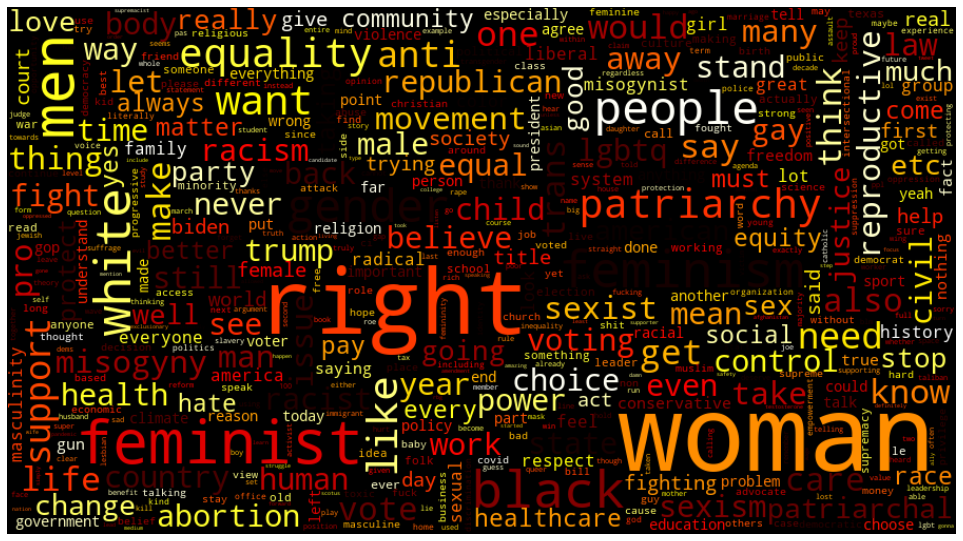

In [72]:
wordfreq = Counter(flat_list)

# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='hot',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)

plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

For Visualizing in Embedding Projector

In [17]:
meta_file = "w2x_metadata.tsv"
placeholder = np.zeros((len(model.wv.index_to_key), model.vector_size))

with open(meta_file, 'wb') as file_metadata:
    for i, word in enumerate(model.wv.index_to_key):
        placeholder[i] = model.wv[word]
        # temporary solution for https://github.com/tensorflow/tensorflow/issues/9094
        if word == '':
            print("Emply Line, should replecaed by any thing else, or will cause a bug of tensorboard")
            file_metadata.write("{0}".format('<Empty Line>').encode('utf-8') + b'\n')
        else:
            file_metadata.write("{0}".format(word).encode('utf-8') + b'\n')

Emply Line, should replecaed by any thing else, or will cause a bug of tensorboard


In [36]:
list_vec = []
import csv
with open('wv_embeddings.tsv', 'w') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t')
    for i in range(len(list_lemmatized)):
        for word in list_lemmatized[i]:
            vector = model.wv[word].tolist()
            list_vec.append(vector)
            writer.writerow(vector)

In [ ]:
list_word = []

with open('wv_embeddings_words.tsv', 'w') as tsvfile:
    for i in range(len(list_lemmatized)):
        for index, word in enumerate(list_lemmatized[i]):
            #print(word)
            list_word.append(word)
            #vector = model.wv[word].tolist()
            tsvfile.write(word + '\t')

In [14]:
print(len(list_vec), len(list_word))

729669 729669


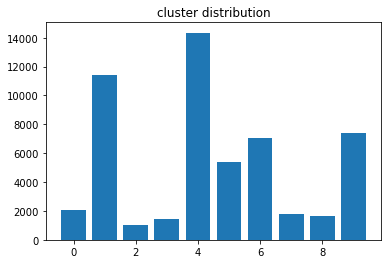

In [71]:
def show_cluster_distribution(kmeans_bert):
    cluster_count = []
    c = Counter(kmeans_bert.labels_)
    fig, ax = plt.subplots()
    for cur_class in sorted(list(c.keys())):
        cluster_count.append(c[cur_class])
    # plt.hist(list(range(len(class_dict))),class_dict)
    plt.bar(list(range(10)), cluster_count)
    plt.title("cluster distribution")
    
show_cluster_distribution(kmeans_w2v)


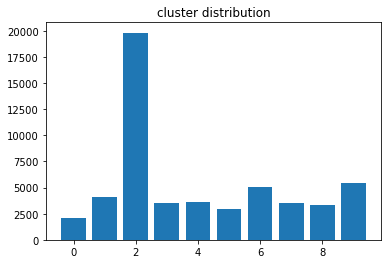

In [73]:
show_cluster_distribution(kmeans_ti)

In [ ]:
from sklearn.decomposition import PCA 



